Import packages and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from typing import Sequence, Dict, Any, Tuple
import importlib

In [2]:
path_CAN = os.path.abspath("..")
path_PM = os.getcwd().replace('CAN', 'Plasticity_Model')
print("CWD:", os.getcwd())
print("plast mod wd:", path_PM)
sys.path.insert(0, path_CAN)
sys.path.insert(0, path_PM)

CWD: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN
plast mod wd: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/Plasticity_Model


In [3]:
from CAN.CAN_network import CANNetwork
from CAN.CAN_simulator import CANSimulator

Initialize model

In [ ]:
K = 364
net = CANNetwork(K = K)
sim = CANSimulator(network = net)

In [20]:
init = sim.init_state(T=10)

In [31]:
initial_phase = 0.0
end_phase = 360.0

In [32]:
wlm_vel = 0.42

scale_02, scale_05, scale_08 = 0.10001865732646281, 0.09990768145972807, 0.09961380494084472

wolm_02=max([0.34, 0.33, 0.34, 0.34, 0.33])
wolm_05=max([0.35, 0.34, 0.35, 0.34, 0.35])
wolm_08=max([0.33, 0.36, 0.32, 0.34, 0.33])

# mean dist / scale
mean_dist_02 = np.array([63.1 , 121.95, 182.6 , 243.55, 305.1])
mean_dist_05 = np.array([63.35, 122.8 , 184.45, 246.3 , 308.25])
mean_dist_08 = np.array([63.65, 124.  , 185.95, 248.15, 310.5 ])

## What did the authors do?

1. Compute trajectories of **network states** (ring phase) over time (*out['nn_state']* from *run_trial* output)
    - LM model: with_lm trajectories
    - NoLM model: wo_lm trajectories

2. Define base times --> [0.65, 1.30, 1.95, 2.60, 3.25]: hard-coded task times at which endogenous landmarks should appear

3. From the with_lm trajectories:
    - compute a *median trajectory*
    - extract the *target states* at base times

4. For each simulation and each state_base:
    - compute the **first time** the trajectory hits or crosses that state
    - --> this is the **produced time** (temporal distance) for base interval

5. Then plot:
    - **std(produced time at base_int t)** vs **base_time(t)** for all base times
    - for both lm model and nolm model

### 1. Run n_trials using the simulator
Produce a list of trajectories

In [50]:
n_trials = 50

In [51]:
def simulate_trajectories(
        sim: CANSimulator,
        init,
        wm: float,
        v_base: float,
        landmarkpresent: bool,
        n_trials: int = 50,
        initial_phase: float = 30.0,
        end_phase: float = 360.0,
        landmark_input_loc=(60, 120, 180, 240, 300),
    ) -> list[np.ndarray]:
    """
    Run `n_trials` CAN simulations under one condition
    (with or without landmarks) and return the list of nn_state trajectories.
    """
    net = sim.network
    trajectories: list[np.ndarray] = []

    for _ in range(n_trials):

        # run the trial
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=landmarkpresent,
            landmark_input_loc=landmark_input_loc,
            wolm_speed=v_base,      # only one of these is actually used
            wlm_speed=v_base,       # depending on `landmarkpresent`
            wm=wm,
            T_max=60.0,
            landmark_onset_steps=500,
            landmark_tau_steps=1500,
            #align_input_bump=True,
        )

        trajectories.append(out["nn_state"])   # np.ndarray of ints

    return trajectories

In [52]:
# try with wm=0.05
wm = 0.05

traj_lm = simulate_trajectories(
    sim, init,
    wm= wm, v_base= wlm_vel,
    landmarkpresent= True,
    n_trials = n_trials,
    initial_phase = initial_phase,
    end_phase= end_phase,
    )

traj_wolm = simulate_trajectories(
    sim, init,
    wm= wm, v_base= wolm_05,
    landmarkpresent= False,
    n_trials = n_trials,
    initial_phase = initial_phase,
    end_phase= end_phase,
    )

### 2. Define base times:

In [53]:
base_times = [0.65, 1.30, 1.95, 2.60, 3.25]

### 3. Get median LM_trajectories and target states at base times

In [54]:
def compute_target_states_from_median_lmtraj(
        net,
        traj_lm,
        base_times,
        scale_sim2task = 1.0,
        ):
    """
    STEP 1
    - Pad w/ NaNs, compute median trajectory across sims (WITH landmarks).
    - Extract target states at base_times in TASK seconds.

    need to convert model time into task time:
        task_time = sim_time * scale
        => sim_time = task_time / scale
    Returns:
        median_traj (T,)
        t_task (T,)    time axis in task seconds
        target_state (len(base_times_task),)
    """
    dt = net.dt
    base_times_task = np.asarray(base_times, dtype=float)

    maxlen = max(len(tr) for tr in traj_lm)
    mat = np.full((len(traj_lm), maxlen), np.nan, dtype=float)
    for i, tr in enumerate(traj_lm):
        mat[i, :len(tr)] = tr

    median_traj = np.nanmedian(mat, axis=0)  # (T,)
    t_sim = np.arange(maxlen) * dt
    t_task = t_sim * scale_sim2task

    target_state = np.zeros_like(base_times_task)
    for j, tb in enumerate(base_times_task):
        idxs = np.where(t_task >= tb)[0]
        if len(idxs) == 0:
            raise RuntimeError(
                f"Base time {tb:.3f}s exceeds median simulated duration "
                f"({t_task[-1]:.3f}s in task time)."
            )
        idx = idxs[0]
        target_state[j] = median_traj[idx]

    return median_traj, t_task, target_state


### 4. Compute the Produced time for each base time
- For each simulated trajectory and each target state: compute the first time the trajectory reaches or crosses that state

- returns the time in task times

In [55]:
def compute_produced_times_first_passage(
    net,
    trajectories,
    target_states: np.ndarray,
    scale_sim_to_task: float = 1.0,
) -> np.ndarray:
    """
    For each simulation trajectory and each target state:
    produced time = first time the trajectory reaches/crosses that state.

    Returns:
        rt_task: shape (n_sims, n_targets) in TASK seconds (scaled).
                NaN if not reached.
    """
    dt = net.dt
    target_states = np.asarray(target_states, dtype=float)
    n_sims = len(trajectories)
    n_targets = len(target_states)

    rt_sim = np.full((n_sims, n_targets), np.nan, dtype=float)

    for i, tr in enumerate(trajectories):
        tr = np.asarray(tr, dtype=float)
        for j, s_target in enumerate(target_states):
            idx = np.where(tr >= s_target)[0]
            if len(idx) == 0:
                continue
            rt_sim[i, j] = idx[0] * dt

    rt_task = rt_sim * scale_sim_to_task
    return rt_task

### 5. Stats and Plot

In [60]:
def stats_and_plot_variability(
        base_times_task: np.ndarray,
        rt_wlm_task: np.ndarray,
        rt_wolm_task: np.ndarray,
        title: str = None,
    ):
    """
    STEP 3
    Compute mean & std of produced times across simulations for each base interval,
    and plot std vs base interval (Fig 4d-like).
    """
    base_times_task = np.asarray(base_times_task, dtype=float)

    mean_wlm = np.nanmean(rt_wlm_task, axis=0)
    std_wlm  = np.nanstd(rt_wlm_task, axis=0)

    mean_wolm = np.nanmean(rt_wolm_task, axis=0)
    std_wolm  = np.nanstd(rt_wolm_task, axis=0)

    # Plot: STD vs base interval
    plt.figure(figsize=(5.5, 4.5))
    plt.plot(base_times_task, std_wolm, marker="o", label="No LM", color = 'black')
    plt.plot(base_times_task, std_wlm, marker="o", label="With LM", color = 'red')
    plt.xlabel("Base interval (task s)")
    plt.ylabel("SD produced time (task s)")
    plt.xticks(base_times_task)
    plt.legend()
    plt.title('Bootstrapped SD(time dist) vs mean time dist')
    if title:
        os.makedirs('Fig_CAN', exist_ok=True)
        plt.savefig(f'Fig_CAN/Fig_4d_{title}.png', dpi=300, bbox_inches="tight")
    plt.tight_layout()
    #plt.show()

    return {
        "base_times": base_times_task,
        "mean_wlm": mean_wlm, "std_wlm": std_wlm,
        "mean_wolm": mean_wolm, "std_wolm": std_wolm,
    }

## Final execution

In [57]:
# i have traj_lm and traj_nolm

# step 3 --> median trajs and target states
median_traj, t_task, target_states = compute_target_states_from_median_lmtraj(
    net = net,
    traj_lm = traj_lm,
    base_times= base_times,
    scale_sim2task= scale_05,
)

In [58]:
# step 4 --> produced times for each base time
rt_wlm_task = compute_produced_times_first_passage(
    net= net,
    trajectories = traj_lm,
    target_states = target_states,
    scale_sim_to_task= scale_05
)

rt_wolm_task = compute_produced_times_first_passage(
    net= net,
    trajectories = traj_wolm,
    target_states = target_states,
    scale_sim_to_task= scale_05
)

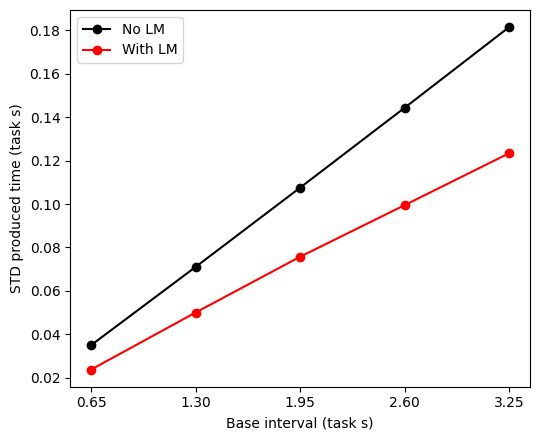

In [59]:
# step 5 --> compute std and plot variability 
summary = stats_and_plot_variability(
    base_times_task = base_times,
    rt_wlm_task = rt_wlm_task,
    rt_wolm_task= rt_wolm_task
)

try it with wm= 0.08

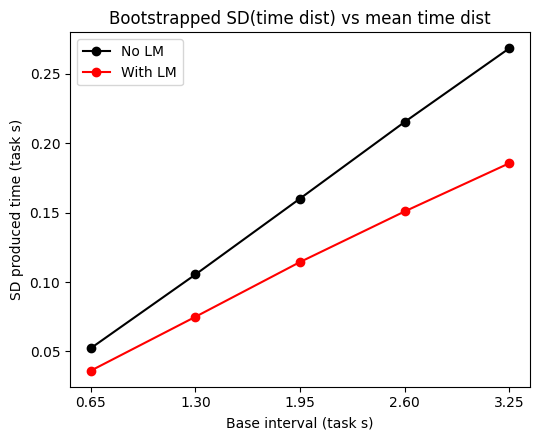

In [62]:
# try with wm=0.08
wm = 0.08

# step 1: trajectories 
traj_lm = simulate_trajectories(
    sim, init,
    wm= wm, v_base= wlm_vel,
    landmarkpresent= True,
    n_trials = n_trials,
    initial_phase = initial_phase,
    end_phase= end_phase,
    )

traj_wolm = simulate_trajectories(
    sim, init,
    wm= wm, v_base= wolm_08,
    landmarkpresent= False,
    n_trials = n_trials,
    initial_phase = initial_phase,
    end_phase= end_phase,
    )

# ----------------------------
# step 2: base times
base_times = [0.65, 1.30, 1.95, 2.60, 3.25]

# ----------------------------
# step 3: median trajs and target states
median_traj, t_task, target_states = compute_target_states_from_median_lmtraj(
    net = net,
    traj_lm = traj_lm,
    base_times= base_times,
    scale_sim2task= scale_08,
)

# ----------------------------
# step 4: produced times for each base time
rt_wlm_task = compute_produced_times_first_passage(
    net= net,
    trajectories = traj_lm,
    target_states = target_states,
    scale_sim_to_task= scale_08
)

rt_wolm_task = compute_produced_times_first_passage(
    net= net,
    trajectories = traj_wolm,
    target_states = target_states,
    scale_sim_to_task= scale_08
)

# ----------------------------
# step 5 --> compute std and plot variability 
summary = stats_and_plot_variability(
    base_times_task = base_times,
    rt_wlm_task = rt_wlm_task,
    rt_wolm_task= rt_wolm_task,
    title = 'wm_08'
)


## Final run with wm=0.05

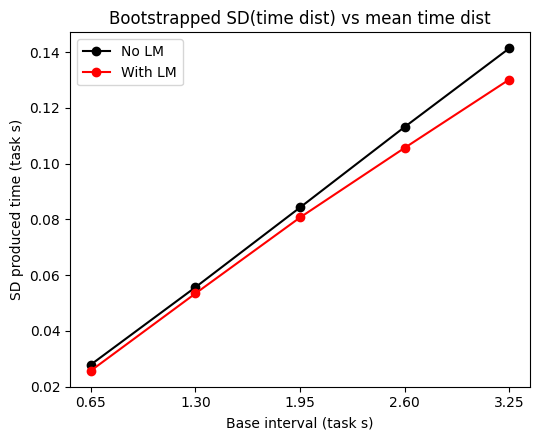

In [61]:
# try with wm=0.05
wm = 0.05

# step 1: trajectories 
traj_lm = simulate_trajectories(
    sim, init,
    wm= wm, v_base= wlm_vel,
    landmarkpresent= True,
    n_trials = n_trials,
    initial_phase = initial_phase,
    end_phase= end_phase,
    )

traj_wolm = simulate_trajectories(
    sim, init,
    wm= wm, v_base= wolm_05,
    landmarkpresent= False,
    n_trials = n_trials,
    initial_phase = initial_phase,
    end_phase= end_phase,
    )

# ----------------------------
# step 2: base times
base_times = [0.65, 1.30, 1.95, 2.60, 3.25]

# ----------------------------
# step 3: median trajs and target states
median_traj, t_task, target_states = compute_target_states_from_median_lmtraj(
    net = net,
    traj_lm = traj_lm,
    base_times= base_times,
    scale_sim2task= scale_05,
)

# ----------------------------
# step 4: produced times for each base time
rt_wlm_task = compute_produced_times_first_passage(
    net= net,
    trajectories = traj_lm,
    target_states = target_states,
    scale_sim_to_task= scale_05
)

rt_wolm_task = compute_produced_times_first_passage(
    net= net,
    trajectories = traj_wolm,
    target_states = target_states,
    scale_sim_to_task= scale_05
)

# ----------------------------
# step 5 --> compute std and plot variability 
summary = stats_and_plot_variability(
    base_times_task = base_times,
    rt_wlm_task = rt_wlm_task,
    rt_wolm_task= rt_wolm_task,
    title = 'wm_05'
)
